# Mastr #

Mastr es la nueva herramienta de valoración y agregación diseñada encima de PALM, que permite describir carteras y escenarios de riesgo de manera separada a la implementación de los pricers y los objetos. PALM se utiliza para poder distribuir la carga tanto en valoración como agregación, eliminando cuellos de botella y permitiendo la ejecución escalable en paralelo de todo el flujo de trabajo.

Uno de los problemas a resolver de las herramientas actuales es que el desarrollo de pricers y objetos está muy relacionado con la propia infraestructura. El objeto `curva` incluye la mayoría de la lógica para pasar de datos de mercado a lógica de evaluación.

Mastr incluye un *sandbox* diseñado para poder implementar pricers y objetos de manera sencilla y ensayar la ejecución de scripts `IDN`, un formato de descripción de carteras y escenarios de valoración.

Además, Mastr incluye una librería en Python que cubre algunas tareas comunes en la implementación de pricers y objetos, como calendarios, bootstrap, interpolaciones...

## Desarrollo de pricers ##

Un pricer en Mastr no es más que una función. Pero antes hay que cargar el sandbox

In [1]:
from mastr.idn.sandbox import Sandbox
sandbox = Sandbox()

Vamos a construir un pricer para un bono que nos vamos a inventar. Es un bono que vale 0 mientras no haya pasado 1.5 fracciones de año desde la fecha de firma. En cuanto se supere ese tiempo, el bono vale un 5% más que el strike price.

In [2]:
from datetime import date

def newbond(strike, signed, time, daycount):
    signed = date(*map(int, signed.split('-')))
    time = date(*map(int, time.split('-')))
    
    yearfrac = daycount(signed, time)
    
    if yearfrac > 1.5:
        return (1 + 0.05) * strike
    else:
        return 0.0

Lo mejor es que ahora lo podemos probar, hacer test unitarios... De mastr importaremos el objeto que cuenta fracciones de año.

In [3]:
from mastr.bootstrapping.daycount import DayCounter

value = newbond(100, '2016-9-7', '2017-9-10', DayCounter('actual/360'))
print(value)

value = newbond(100, '2016-9-7', '2018-9-10', DayCounter('actual/360'))
print(value)

0.0
105.0


Pero mastr está diseñado para ejecutar IDN, los scripts de descripción de carteras y de escenarios.

In [4]:
sandbox.add_pricer(newbond)
sandbox.add_object(DayCounter)

In [5]:
%cat data/script.json

[
    { 
        "name": "eval1",
        "pricer": "newbond",
        "args": [100.0,
                 "#arg#2016-9-7",
                 "#arg#2018-9-7",
                 { 
                     "name": "DayCounter",
                     "data": "#arg#actual/360"
                 }
                 ]
    }
]


In [6]:
with open('data/script.json') as f:
    results = sandbox.eval(f.read())
    
print(results)

2016-09-06 12:33:26,202 - IDN sandbox - DEBUG - Start traversing the IDN tree
2016-09-06 12:33:26,209 - IDN sandbox - WARNING - No key found, just pass the script
2016-09-06 12:33:26,217 - IDN sandbox - DEBUG - Eval scenario #0
[{'eval1': 105.0}]


El intérprete de IDN está preparado para poder evaluar la cartera con múltiples escenarios. En este caso, vamos a evaluar distintos escenarios temporales.

In [7]:
%cat data/scriptdata.json

[
    { 
        "name": "eval1",
        "pricer": "newbond",
        "args": [100.0,
                 "#arg#2016-9-7",
                 "#vec#time",
                 { 
                     "name": "DayCounter",
                     "data": "#arg#actual/360"
                 }
                 ]
    }
]


In [8]:
%cat data/data.json

{ "#vec#time": ["r1","r2","r3","r4","r5"],
  "r1"  :"#arg#2016-9-10",
  "r2"  :"#arg#2016-12-10",
  "r3"  :"#arg#2017-9-10",
  "r4"  :"#arg#2018-9-10",
  "r5"  :"#arg#2019-9-10"
}


Este nuevo fichero JSON, que contiene los datos de distintos escenarios, no es más que un nuevo argumento para el sandbox.

In [9]:
with open('data/scriptdata.json') as f:
    with open('data/data.json') as g:
        results = sandbox.eval(f.read(), g.read())
        

2016-09-06 12:33:26,633 - IDN sandbox - DEBUG - Set key r5
2016-09-06 12:33:26,647 - IDN sandbox - DEBUG - Set key r2
2016-09-06 12:33:26,655 - IDN sandbox - DEBUG - Set key #vec#time
2016-09-06 12:33:26,678 - IDN sandbox - DEBUG - Set key r4
2016-09-06 12:33:26,682 - IDN sandbox - DEBUG - Set key r1
2016-09-06 12:33:26,687 - IDN sandbox - DEBUG - Set key r3
2016-09-06 12:33:26,692 - IDN sandbox - DEBUG - Start traversing the IDN tree
2016-09-06 12:33:26,698 - IDN sandbox - DEBUG - Add key #vec#time
2016-09-06 12:33:26,706 - IDN sandbox - DEBUG - Building stack successfully
2016-09-06 12:33:26,719 - IDN sandbox - DEBUG - Eval scenario #0
2016-09-06 12:33:26,725 - IDN sandbox - DEBUG - Eval scenario #1
2016-09-06 12:33:26,731 - IDN sandbox - DEBUG - Eval scenario #2
2016-09-06 12:33:26,733 - IDN sandbox - DEBUG - Eval scenario #3
2016-09-06 12:33:26,735 - IDN sandbox - DEBUG - Eval scenario #4


In [10]:
print(results)

[{'eval1': 0.0}, {'eval1': 0.0}, {'eval1': 0.0}, {'eval1': 105.0}, {'eval1': 105.0}]


Finalmente, podemos utilizar las capacidades de representación gráfica para analizar los resultados y la evolucion en los tiempos dados del valor de este bono.

<IPython.core.display.Javascript object>


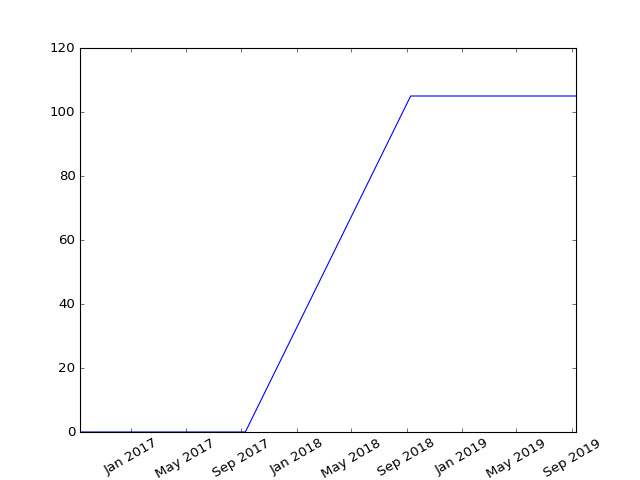

[None, None, None, None, None, None, None, None, None]

In [11]:
import matplotlib.pyplot as plt
import json
%matplotlib notebook

dates = [
    date(2016,9,10),
    date(2016,12,10),
    date(2017,9,10),
    date(2018,9,10),
    date(2019,9,10)
        ]

fig1 = plt.figure(1)
ax = fig1.add_subplot(1,1,1)
ax.plot(dates, [r['eval1'] for r in results])
plt.setp(ax.get_xticklabels(), rotation=30)